In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import cmocean
from matplotlib import pyplot as plt

In [3]:
import os
import pathlib
import sys
from subprocess import call

In [4]:
from datetime import datetime

In [5]:
from datetime import datetime, timedelta

In [6]:
import numpy as np
import pandas as pd
import xarray as xr

In [7]:
sys.path.append("../code/")

In [8]:
import src

### parameters for papermill 

In [9]:
domain = "NZ"
dpath = "/media/nicolasf/END19101/data/OISST/daily"
clim_path = "/home/nicolasf/operational/OISST_indices/outputs/"
ndays_agg = 1
ndays_back = 365 * 2
quantile = 0.9
lag = 0

### get the pathlib paths for the data and the climatology 

In [10]:
dpath = pathlib.Path(dpath).joinpath(domain)
clim_path = pathlib.Path(clim_path).joinpath(domain)

### get the current date 

In [11]:
current_date = datetime.utcnow()

### get the first day of the period to extract 

In [12]:
first_day = current_date - timedelta(days=ndays_back)

## get the years to read 

In [13]:
years_to_get = np.unique(np.arange(first_day.year, current_date.year + 1))

In [14]:
lfiles = [dpath.joinpath(f"sst.day.mean.{year}.v2.nc") for year in years_to_get]

## opens the near realtime dataset 

In [15]:
dset = xr.open_mfdataset(lfiles, parallel=True, combine="by_coords")

In [16]:
dset

<xarray.Dataset>
Dimensions:  (time: 952, lat: 80, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2022-08-09
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(366, 80, 72), meta=np.ndarray>

## calculates the rolling averages here !!! 

In [17]:
if ndays_agg > 1:

    dset = dset.rolling({'time':ndays_agg}, min_periods=ndays_agg, center=False).mean('time')
    
    dset = dset.isel(time=slice(ndays_agg+1, None))

### get rid of the 29th of Feb if present 

In [18]:
dset = dset.convert_calendar("noleap")

### opens the climatology 

In [19]:
clim = xr.open_zarr(
    clim_path.joinpath(f"{domain}_OISST_{ndays_agg}days_climatology_15_window.zarr")
)

In [20]:
clim

<xarray.Dataset>
Dimensions:    (lat: 80, lon: 72, dayofyear: 365, quantile: 5)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon        (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
  * quantile   (quantile) float64 0.1 0.25 0.5 0.75 0.9
Data variables:
    average    (lat, lon, dayofyear) float64 dask.array<chunksize=(20, 18, 183), meta=np.ndarray>
    quantiles  (dayofyear, quantile, lat, lon) float64 dask.array<chunksize=(92, 2, 20, 36), meta=np.ndarray>
    std        (lat, lon, dayofyear) float64 dask.array<chunksize=(20, 18, 183), meta=np.ndarray>

### calculate the anomalies with respect to the 1991-2020 average

In [21]:
anoms = dset.groupby(dset.time.dt.dayofyear) - clim["average"]

### repeat the climatology over the time dimension 

In [22]:
clim_repeat = clim.sel(dayofyear=dset.time.dt.dayofyear)

In [23]:
clim_repeat

<xarray.Dataset>
Dimensions:    (lat: 80, lon: 72, time: 951, quantile: 5)
Coordinates:
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 214 215 216 217 218 219 220 221
  * lat        (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon        (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
  * quantile   (quantile) float64 0.1 0.25 0.5 0.75 0.9
  * time       (time) object 2020-01-01 00:00:00 ... 2022-08-09 00:00:00
Data variables:
    average    (lat, lon, time) float64 dask.array<chunksize=(20, 18, 183), meta=np.ndarray>
    quantiles  (time, quantile, lat, lon) float64 dask.array<chunksize=(92, 2, 20, 36), meta=np.ndarray>
    std        (lat, lon, time) float64 dask.array<chunksize=(20, 18, 183), meta=np.ndarray>

### derive the mask highlighting MHW conditions

In [24]:
mask = dset["sst"].where(dset["sst"] >= clim_repeat["quantiles"].sel(quantile=quantile))
mask = mask.where(np.isnan(mask), other=1)

### Now select the maps to plot 

In [25]:
dataarray_anoms = anoms.isel(time=(-lag - 1))["sst"]

In [26]:
dataarray_raw = dset.isel(time=(-lag - 1))["sst"]

In [27]:
dataarray_mask = mask.isel(time=(-lag - 1))

### Interpolate over the missing (land) grid points, for smooth plotting 

In [28]:
dataarray_anoms = src.interpolate_NaN_da(dataarray_anoms)

In [29]:
dataarray_raw = src.interpolate_NaN_da(dataarray_raw)

In [30]:
cmap = cmocean.cm.balance

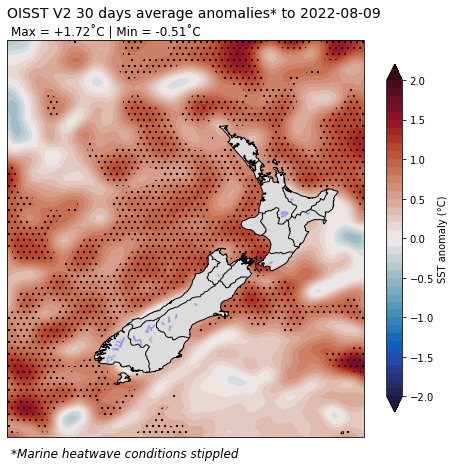

In [31]:
f, ax = src.plot_SST_map(
    dataarray_anoms, dataarray_mask, ndays_agg=ndays_agg, levels=np.arange(-2, 2 + 0.1, 0.1)
)

In [32]:
f.savefig(
    f"/home/nicolasf/Desktop/proto_OISST_anoms_{ndays_agg:02d}_days.png",
    dpi=200,
    bbox_inches="tight",
    facecolor="w",
)

### Now calculates the number of heatwaves days 

In [33]:
heatwaves_days = mask.copy()

In [34]:
heatwaves_days = heatwaves_days.fillna(0)

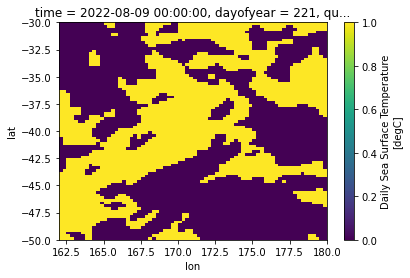

In [35]:
heatwaves_days[-1,:,:].plot()

In [36]:
heatwaves_days = 1 - heatwaves_days

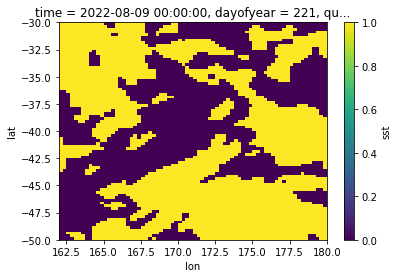

In [37]:
heatwaves_days[-1,:,:].plot()

In [38]:
heatwaves_days_consecutive = heatwaves_days.cumsum(dim='time', keep_attrs=True)

In [39]:
heatwaves_days_consecutive['time'] = (('time'), np.arange(len(heatwaves_days.time))[::-1])

In [40]:
heatwaves_days_consecutive = heatwaves_days_consecutive.idxmax(dim='time')

In [41]:
heatwaves_days_consecutive

<xarray.DataArray 'time' (lat: 80, lon: 72)>
dask.array<where, shape=(80, 72), dtype=float64, chunksize=(10, 36), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon       (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
    quantile  float64 0.9

In [42]:
ess = heatwaves_days_consecutive.stack(z=('lat','lon'))

In [43]:
ess.load()

<xarray.DataArray 'time' (z: 5760)>
array([138., 135., 124., ...,  47.,  12.,   8.])
Coordinates:
    quantile  float64 0.9
  * z         (z) object MultiIndex
  * lat       (z) float32 -49.88 -49.88 -49.88 -49.88 ... -30.12 -30.12 -30.12
  * lon       (z) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9

In [44]:
ess.max()

<xarray.DataArray 'time' ()>
array(416.)
Coordinates:
    quantile  float64 0.9

In [45]:
ess.idxmax()['lon']

<xarray.DataArray 'lon' ()>
array(173.375, dtype=float32)
Coordinates:
    quantile  float64 0.9
    lat       float32 -40.12
    lon       float32 173.4

In [46]:
ess.idxmax()['lat']

<xarray.DataArray 'lat' ()>
array(-40.125, dtype=float32)
Coordinates:
    quantile  float64 0.9
    lat       float32 -40.12
    lon       float32 173.4

Text(0, 0.5, 'SST')

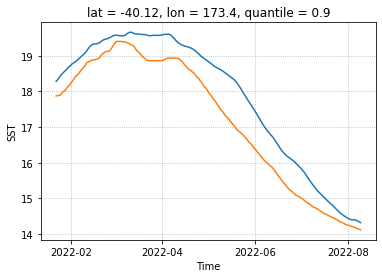

In [47]:
f, ax = plt.subplots()
dset.sel(lat=ess.idxmax()['lat'], lon=ess.idxmax()['lon']).isel(time=slice(-200,None))['sst'].plot(ax=ax)
clim_repeat.sel(lat=ess.idxmax()['lat'], lon=ess.idxmax()['lon'], quantile=0.9).isel(time=slice(-200,None))['quantiles'].plot(ax=ax)
ax.grid(ls=':')
ax.set_ylabel('SST')

Text(0, 0.5, 'SST')

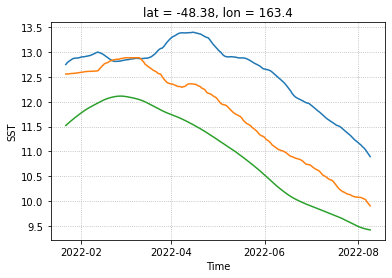

In [48]:
f, ax = plt.subplots()
dset.sel(lat=-48.375, lon=163.375).isel(time=slice(-200,None))['sst'].plot(ax=ax)
clim_repeat.sel(lat=-48.375, lon=163.375, quantile=0.9).isel(time=slice(-200,None))['quantiles'].plot(ax=ax)
clim_repeat.sel(lat=-48.375, lon=163.375).isel(time=slice(-200,None))['average'].plot(ax=ax)
ax.grid(ls=':')
ax.set_ylabel('SST')

In [ ]:
import palettable

In [ ]:
cmap = palettable.scientific.sequential.Bilbao_20.mpl_colormap

In [ ]:
cmap

In [ ]:
import cartopy.feature as cfeature
land = cfeature.NaturalEarthFeature("physical", "land", "10m")

In [ ]:
from cartopy import crs as ccrs

In [ ]:
f, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

days_since.plot(ax=ax, levels=np.arange(0,200, 10), transform=ccrs.PlateCarree(), cmap=cmap)

ax.coastlines()

ax.add_feature(land, facecolor="gainsboro")

In [ ]:
days